# Worksheet 17

Name: Hrishav Varma

UID: U57996211

Name: Pranav Goyanka

UID: U18853014

Name: Ria Singh

UID: U21576658

Name: Arunesh Kumar Lal

UID: U26502933

Name: Sonja Poe 

UID: U15566089

Name: Sri Harsha Kotamraju 

UID: U57771922

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

Start by compiling a dataset by tracking users' likes and dislikes. Then, utilize collaborative filtering techniques to identify similarities among users based on their preferences. This similarity assessment enables the system to recommend items that similar users have liked but the current user has not yet interacted with. The core of the recommendation engine is a binary rating matrix, where users are rows, items are columns, and entries represent whether a user likes (1) or dislikes (0) an item. By analyzing these binary interactions, the system can generate personalized recommendations suited to each user's tastes, despite the absence of nuanced ratings.

b) Describe 3 challenges of building a recommender system

Cold start: when new users or items lack sufficient data for accurate recommendations
Scalability: as the system grows, the system must be able to handle the additional computation
Sparsity: makes it difficult to find similar moves or users

c) Why is SVD not an option for collaborative filtering?

SVD struggles with sparsity and cannot handle missing values directly, common occurrences in collaborative filtering datasets. Moreover, SVD's computational demands make it impractical for large-scale collaborative filtering tasks, prompting the preference for more efficient techniques like matrix factorization methods tailored for sparse data.

d) Use the code below to train a recommender system on a dataset of amazon movies

In [1]:
%pip install findspark

  Obtaining dependency information for findspark from https://files.pythonhosted.org/packages/a4/cb/7d2bb508f4ca00a043fd53e8156c11767799d3f534bf451a0942211d5def/findspark-2.0.1-py2.py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\hrish\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
c:\Users\hrish\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
c:\Users\hrish\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Kaggle RMSE =  1.435297482015794


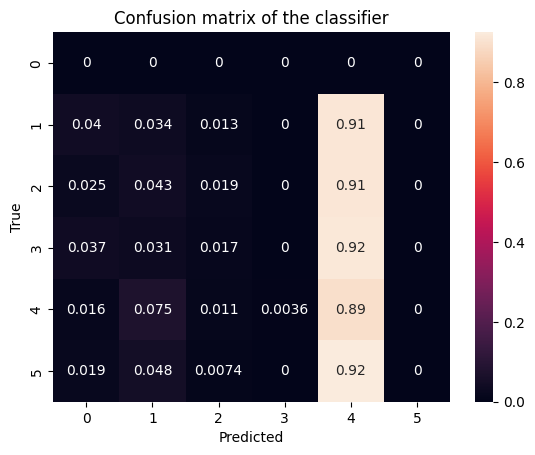

In [2]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
param_grid = ParamGridBuilder().addGrid(
        als.rank, [10, 50]).addGrid(
        als.regParam, [.1]).addGrid(
        als.maxIter, [10]).build()
evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="Score", 
        predictionCol="prediction")
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
cv_fit = cv.fit(df)
rec_sys = cv_fit.bestModel

# rec_sys = als.fit(df)
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()

X_test_merged = X_test_processed.merge(rec, on=['UserId_fact', 'ProductId_fact'], how='left')

average_score = init_df['Score'].mean()
X_test_merged['prediction'] = X_test_merged['prediction'].fillna(average_score)

print("Kaggle RMSE = ", mean_squared_error(Y_test, X_test_merged['prediction'], squared=False))

cm = confusion_matrix(Y_test, X_test_merged['prediction'].astype(int), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()